In [1]:
import os
import ast
import ineqpy
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from pathlib import Path

In [2]:
path_data = Path("../data")
path_meta = Path("../meta")

font_size = 15

platform_abbreviation_mapping = {
    'gh': 'GitHub',
    'hf': 'Hugging Face Spaces',
    'pwc': 'Papers With Code',
    'ip': 'independent platform',
}

platform_abbreviation_mapping_inverse = {v: k for k, v in platform_abbreviation_mapping.items()}

leaderboard_organization_tactics_mapping = {
    'Algorithm': ['Algorithm'],
    'Evaluation Configuration': ['Dataset Slice', 'Evaluator', 'Metric'],
    'Leaderboard Aggregation': ['Aggregated Result'],
    'Leaderboard Release': ['Leaderboard Launch Date', 'Leaderboard Version'],
    'Model Capability': ['Benchmark Dataset', 'Service Load', 'Supported Functionality', 'Supported Language', 'Supported Modality', 'Task'],
    'Model Information': ['Model Accessibility', 'Model Size', 'Model Type'],
    'Prompt Engineering': ['#Prompt Example', 'Output Length', 'Prompt Design', 'Prompt Length', 'Relation Extractor', 'Tokenizer']
}

pwc_organization_strategies = {'Task'}

submission_avenue_synonyms = {
    'Competition': ['Hackathon']
}

leaderboard_system_without_evaluation_datasets = ['Hackathon Somos NLP 2023 Leaderboard', 'Somos NLP Likes Leaderboard', 'Ko Chatbot Arena Leaderboard']

leaderboard_system_without_pull_requests = ['FSMBench', 'CompMix', 'DocVQA', 'GENIE', 'InfographicVQA', 'LMExamQA', 'Models Leaderboard', 'MP-DocVQA', 'OpenEval (text)', 'Program Synthesis Models Leaderboard', 'ProtoQA', 'TextSynth Server']

leaderboard_system_without_contacts = ['OpenEval (text)']

leaderboard_system_without_documentation = ['Hackathon Somos NLP 2023 Leaderboard', 'Somos NLP Likes Leaderboard', 'FSMBench']

leaderboard_system_without_evaluation_harness = ['Hackathon Somos NLP 2023 Leaderboard', 'Somos NLP Likes Leaderboard', 'LLM-Leaderboard']

workflow_patterns_with_submission = ['1', '2', '3', '4', '5']

macro_display_format_mapping = {
    'Table': ['Regular Table', 'Rankable Table', 'Table Screenshot'],
    'Figure': ['Bar Chart', 'Box Plot', 'Heat Map', 'Line Chart', 'Pie Chart', 'Radar Chart', 'Scatter Plot', 'Rankable Bar Chart'],
}

publisher_synonyms = {
    'Alibaba Group': ['Alibaba Group DAMO Academy', 'Aliyun'],
    'Amazon': ['Amazon Alexa AI Lab', 'Amazon AWS AI Lab'],
    'Agency for Science Technology and Research': ['A*STAR I2R', 'CFAR A*STAR'],
    'Bauhaus University': ['Bauhaus University Weimar'],
    'ByteDance': ['ByteDance AI Lab'],
    'Fraunhofer Society': ['Fraunhofer Institute for Integrated Circuits'],
    'Frédéric Joliot Institute for Life Sciences': ['NeuroSpin'],
    'Google': ['Google Brain', 'Google DeepMind', 'Google Blueshift'],
    'Huawei': ["Huawei Noah's Ark Lab"],
    'Kunlun Tech': ['Skywork'],
    'Max Planck Society': ['Max Planck Institute for Informatics', 'Max Planck Institute for Intelligent Systems', 'Max Planck Institute for Mathematics in the Sciences'],
    'Meta': [
        'Meta FAIR',
        'Meta GenAI'
    ],
    'Microsoft': ['Microsoft Research Asia'],
    'National Public School': ['National Public School HSR Layout'],
    'Naver': ['Naver Labs Europe'],
    'Queen\'s University Kingston': ['Queen\'s University'],
    'Tencent': [
        'Tencent AI Lab',
        'Tencent ARC Lab',
        'Tencent Youtu Lab'
    ],
    'Toyota Technological Institute': ['Toyota Technological Institute Chicago'],
    'University of California': [
        'University of California Berkeley',
        'University of California Davis',
        'University of California Irvine',
        'University of California Los Angeles',
        'University of California Santa Barbara',
        'University of California San Diego',
    ],
    'University of Michigan': ['University of Michigan Ann Arbor'],
    'University of North Carolina': ['University of North Carolina Chapel Hill'],
    'University of Illinois': ['University of Illinois Chicago', 'University of Illinois Urbana Champaign'],
    'University of Massachusetts': ['University of Massachusetts Amherst'],
    'University of Maryland': ['University of Maryland College Park'],
    'University of Tennessee': ['University of Tennessee Knoxville'],
    'University of Texas': ['University of Texas Austin'],
    'University of Wisconsin': ['University of Wisconsin Madison'],
}

metrics_synonyms = {
    'accuracy': [
        'acc',
        'accuarcy',
        'qa accuracy'
    ],
    'average': [
        'avg',
        '平均'
    ],
    'average accuracy': [
        'avg. accuracy'
    ],
    'average score': ['平均分'],
    'bleu': ['bleu score'],
    'bleu-1': [
        'narrativeqa bleu-1',
        'socialiqa bleu-1',
        'mcscript bleu-1',
        'cosmosqa bleu-1'
    ],
    'bleu-4': ['bleu4'],
    'bertscore': ['bert score'],
    'code': ['代码'],
    'elo rating': [
        'chatbot arena elo',
        'elo'
    ],
    'exact match': ['em', 'exact match accuracy'],
    'lerc': [
        'cosmosqa lerc',
        'mcscript lerc',
        'socialiqa lerc',
        'narrativeqa lerc'
    ],
    'link': ['url'],
    'mean rank': [
        'text-to-video mean rank',
        'video-to-text mean rank'
    ],
    'median rank': [
        'text-to-video median rank',
        'video-to-text median rank',
        'text-to-videomedian rank',
        'text-to-video medianr'
    ],
    'meteor': [
        'cosmosqa meteor',
        'narrativeqa meteor',
        'socialiqa meteor',
        'mcscript meteor'
    ],
    'neg mean rank': [
        'i->t neg mean rank',
        't->i neg mean rank'
    ],
    'organization': [
        '发布机构',
        '机构',
        'orgaisation',
    ],
    'others': ['其他'],
    'overall': ['xiezhi overall'],
    'overall score': [
        '总分',
        '总体分数'
    ],
    'pass@1': [
        'interview pass@1',
        'competition pass@1',
        'introductory pass@1'
    ],
    'pass@5': [
        'interview pass@5',
        'introductory pass@5',
        'competition pass@5'
    ],
    'pass@1000': [
        'interview pass@1000',
        'competition pass@1000',
        'introductory pass@1000'
    ],
    'pass@any': [
        'introductory pass@any',
        'competition pass@any',
        'interview pass@any'
    ],
    '#parameters':  [
        '#p',
        '#params',
        '# params',
        '#size',
        '参数量',
        'model size',
        'model size/b',
        'number of params',
        'param',
        'parameters',
        'params',
        'size'
    ],
    'perplexity': ['ppl'],
    'precision@1': ['i->t p@1'],
    'precision@20': ['p@20'],
    'recall@1': [
        'r@1',
        'text-to-videor@1',
        'video-to-text r@1',
        'text-to-video r@1',
        'text-to-image r@1',
        'image-to-text r@1'
    ],
    'recall@5': [
        'text-to-image r@5',
        'video-to-text r@5',
        'image-to-text r@5',
        'text-to-video r@5',
        'r@5',
    ],
    'recall@10': [
        'recall@10 on 1 rounds',
        'recall@10 on 2 rounds',
        'recall@10 on 3 rounds',
        'r@10',
        'video-to-text r@10',
        'text-to-image r@10',
        'text-to-video r@10',
        'image-to-text r@10'
    ],
    'recall@50': [
        'text-to-video r@50',
        'video-to-text r@50',
    ],
    'score': ['分数'],
    'submission date': ['提交时间'],
    'top-1 accuracy': ['top 1 accuracy'],
    'top-5 accuracy': ['top 5 accuracy'],
    'type': ['model type'],
    'win rate': ['胜率'],
    'word error rate': ['wer']
}

workflow_pwc = ['1']
display_format_pwc = ['Rankable Table', 'Scatter Plot']
display_format_rankable = ['Rankable Table', 'Rankable Bar Chart']
dashed_model_leaderboards = ['MMCU', 'SuperCLUE-Math6']
non_literature_type = ['blog', 'report', 'white paper']

metrics_synonyms_inverse = {}
for key, values in metrics_synonyms.items():
    for value in values:
        metrics_synonyms_inverse[value] = key

submission_avenue_synonyms_inverse = {}
for key, values in submission_avenue_synonyms.items():
    for value in values:
        submission_avenue_synonyms_inverse[value] = key

macro_display_format_mapping_inverse = {v: k for k, values in macro_display_format_mapping.items() for v in values}

publisher_synonyms_inverse = {}
for key, values in publisher_synonyms.items():
    for value in values:
        publisher_synonyms_inverse[value] = key

leaderboard_organization_tactics_mapping_inverse = {}
for key, values in leaderboard_organization_tactics_mapping.items():
    for value in values:
        leaderboard_organization_tactics_mapping_inverse[value] = key

def convert_df_to_dict(df):
    """
    Convert a DataFrame of leaderboards and metrics to a dictionary.

    :param df: DataFrame with leaderboards and metrics
    :return: Dictionary with leaderboards as keys and list of metrics as values
    """
    leaderboard_data = {}

    # Ensure the DataFrame's first column is considered as the keys
    # and iterate through each row to construct the dictionary
    for _, row in df.iterrows():
        key = row[0]  # The first column serves as the key
        # List comprehension to get non-empty values from the rest of the row
        values = [value for value in row[1:] if pd.notna(value)]
        leaderboard_data[key] = values

    return leaderboard_data

def string_to_list(text, platform=False):
    if pd.isna(text) or text == 'nan':
        return []
    elif platform:
        return [platform_abbreviation_mapping[platform] for platform in text.split(',')]
    else:
        return text.split(',')

def string_to_dict(s, platform=False, list_format=False):
    # Check if the input is np.nan
    if pd.isna(s):
        if list_format:
            return []
        return {}
    
    # Split the string into key-value pairs
    pairs = s.split(',')
    result_dict = {}
    result_list = []
    
    for pair in pairs:
        # Split each pair by ':' to separate keys and values
        key, value = pair.split(':')
        # Split the value by '+' to get the list of items
        value_list = value.split('+')
        # Assign the list to the key in the dictionary
        if platform:
            result_dict[platform_abbreviation_mapping[key]] = value_list
        else:
            result_dict[key] = value_list
        result_list.extend(value_list)
            
    if list_format:
        return result_list
    return result_dict

# Function to format each value based on its own decimal places
def format_individual_value(x):
    if isinstance(x, float):
        # Use string formatting to maintain original decimal places
        return "{:f}".format(x).rstrip('0').rstrip('.')
    return x

def print_empty_folders(root_dir):
    for dirpath, dirname, filenames in os.walk(root_dir):
        # Check if both lists of subdirectories and filenames are empty
        if not filenames and dirpath != root_dir:
            print(f"Empty folder: {dirpath}")
            
def list_directories(folder_path):
    # List all subdirectories within the folder
    directories = [os.path.join(folder_path, d) for d in os.listdir(
        folder_path) if os.path.isdir(os.path.join(folder_path, d))]
    return directories

def publisher_synonyms_mapping(publishers):
    publishers_processed = set()
    for publisher in publishers:
        if publisher in publisher_synonyms_inverse:
            publishers_processed.add(publisher_synonyms_inverse[publisher])
        # elif 'Independent Contributor' == publisher:
        #     publishers_processed.add(leaderboard)
        else:
            publishers_processed.add(publisher)
    return publishers_processed

def submission_avenue_synonyms_mapping(submission_avenue):
    submission_avenue_processed = set()
    for avenue in submission_avenue:
        if avenue in submission_avenue_synonyms_inverse:
            submission_avenue_processed.add(submission_avenue_synonyms_inverse[avenue])
        else:
            submission_avenue_processed.add(avenue)
    return submission_avenue_processed

def keep_rows_by_list_column(df, column_name, keyword_list):
    """
    Filters rows in a DataFrame based on whether all elements in a specified list column are in a given keyword list.
    
    Parameters:
    - df: Pandas DataFrame.
    - column_name: The name of the column containing lists of strings.
    - keyword_list: A list of keywords to check against.
    
    Returns:
    - A filtered Pandas DataFrame.
    """
    # Convert the keyword list to a set for faster membership testing
    keyword_set = set(keyword_list)
    
    # Define a lambda function to check if all elements of a list are in the keyword_set
    all_in_keywords = lambda x: any(element in keyword_set for element in x)
    
    # Apply the lambda function to the specified column and invert the boolean Series to filter rows
    filtered_df = df[df[column_name].apply(all_in_keywords)]
    
    return filtered_df

def filter_rows_by_list_column(df, column_name, keyword_list):
    """
    Filters rows in a DataFrame based on whether all elements in a specified list column are in a given keyword list.
    
    Parameters:
    - df: Pandas DataFrame.
    - column_name: The name of the column containing lists of strings.
    - keyword_list: A list of keywords to check against.
    
    Returns:
    - A filtered Pandas DataFrame.
    """
    # Convert the keyword list to a set for faster membership testing
    keyword_set = set(keyword_list)
    
    # Define a lambda function to check if all elements of a list are in the keyword_set
    all_in_keywords = lambda x: not all(element in keyword_set for element in x)
    
    # Apply the lambda function to the specified column and invert the boolean Series to filter rows
    filtered_df = df[df[column_name].apply(all_in_keywords)]
    
    return filtered_df

In [3]:
xlsx = pd.ExcelFile(path_meta / 'Foundation Model Leaderboards.xlsx')
df_leaderboard = pd.read_excel(xlsx, sheet_name='Leaderboard')

for index, row in df_leaderboard.iterrows():
    os.makedirs(path_data / row['Leaderboard name'], exist_ok=True) 

print_empty_folders(str(path_data))

In [4]:
# import glob

# directory = path_data / 'Vibe-Eval'
# channel = ''
# drop_columns = []

# for file_path in glob.glob(str(directory / "*.csv")):
#     df = pd.read_csv(file_path)#, delimiter=";")
#     df.drop(columns=drop_columns, inplace=True)
#     filename = os.path.basename(file_path)
#     filename = filename.replace(".csv", ".json")
#     if channel:
#         filename = f'{channel}-{filename}'
#     df.to_json(directory / filename, orient="records", indent=4)
#     os.remove(file_path)


In [5]:
total_records = 0
total_leaderboards = 0
total_leaderboard_systems = 0

with pd.ExcelFile(path_meta / 'Foundation Model Leaderboards.xlsx') as excel_file:
    df_leaderboard = pd.read_excel(excel_file, sheet_name='Leaderboard')

    df_leaderboard['Downloadable file formats (non-pwc)'] = df_leaderboard['Downloadable file formats (non-pwc)'].apply(string_to_list)
    df_leaderboard['Leaderboard development workflows (non-pwc)'] = df_leaderboard['Leaderboard development workflows (non-pwc)'].astype(str).apply(string_to_list)
    df_leaderboard['Platforms'] = df_leaderboard['Platforms'].apply(lambda x: string_to_list(x, platform=True))
    df_leaderboard['Display formats (non-pwc)'] = df_leaderboard['Display formats (non-pwc)'].apply(lambda x: string_to_dict(x, platform=True, list_format=True))
    df_leaderboard['Publication venues'] = df_leaderboard['Publication venues'].apply(string_to_list)
    df_leaderboard['Release organizations (non-pwc)'] = df_leaderboard['Release organizations (non-pwc)'].apply(string_to_list)

    df_leaderboard['Display formats'] = [set() for _ in range(len(df_leaderboard))]
    df_leaderboard['Evaluation metrics (pwc)'] = [set() for _ in range(len(df_leaderboard))]
    df_leaderboard['Leaderboard development workflows'] = [set() for _ in range(len(df_leaderboard))]
    df_leaderboard['Participative models'] = [set() for _ in range(len(df_leaderboard))]
    df_leaderboard['Release organizations'] = [set() for _ in range(len(df_leaderboard))]

    for index, row in df_leaderboard.iterrows():
        total_leaderboard_systems += 1
        display_formats = set(row['Display formats (non-pwc)'])
        publishers = publisher_synonyms_mapping(row['Release organizations (non-pwc)'])
        workflows = set(row['Leaderboard development workflows (non-pwc)'])
            
        if row['Platforms'] == ['Papers With Code']:
            publishers.add('Papers With Code')
            
        if 'Papers With Code' in row['Platforms']:
            display_formats = display_formats.union(display_format_pwc)
            workflows = workflows.union(workflow_pwc)
        
        df_leaderboard.at[index, 'Display formats'] = display_formats
        df_leaderboard.at[index, 'Leaderboard development workflows'] = workflows
        df_leaderboard.at[index, 'Release organizations'] = publishers
        df_leaderboard.at[index, '#Display format'] = len(display_formats)
        df_leaderboard.at[index, '#Leaderboard development workflows'] = len(workflows)
        df_leaderboard.at[index, '#Release organization'] = len(publishers)
        df_leaderboard.at[index, '#Host platform'] = len(row['Platforms'])

        records = 0
        leaderboards = 0
        model_names = set()
        template_metrics = set()
    
        for file in os.listdir(path_data / row['Leaderboard name']):
            if not file.endswith('json'):
                continue
            
            host_platform = platform_abbreviation_mapping[file.split('.')[0].split('-')[0]]
            if host_platform not in row['Platforms']:
                continue
        
            file_path = path_data / row['Leaderboard name'] / file
            df = pd.read_json(file_path)
        
            leaderboards += 1
            records += len(df)
            file_name = file.split('/')[-1]
            model_names = model_names.union(set(df['Model']))
            if file_name.startswith('pwc'):
                keys = set()
                for item in df['metrics']:
                    for key in item.keys():
                        key_processed = key.split('(')[0].lower().strip()
                        if key_processed in metrics_synonyms_inverse:
                            keys.add(metrics_synonyms_inverse[key_processed])
                        else:
                            keys.add(key_processed)
                template_metrics = template_metrics.union(keys)
    
        total_records += records
        total_leaderboards += leaderboards
        
        df_leaderboard.at[index, '#Evaluation record'] = records
        df_leaderboard.at[index, '#Participative model'] = len(model_names)
        df_leaderboard.at[index, '#Leaderboard'] = leaderboards
        if template_metrics:
            df_leaderboard.at[index, '#Evaluation metric (pwc)'] = len(template_metrics)
            df_leaderboard.at[index, 'Evaluation metrics (pwc)'] = list(template_metrics)

    df_leaderboard.to_csv(path_meta / 'leaderboard_processed.csv', index=False)

print(f"Total number of leaderboards: {total_leaderboard_systems}")
print(f"Total number of leaderboards: {total_leaderboards}")
print(f"Total number of evaluation records: {total_records}")


Total number of leaderboards: 442
Total number of leaderboards: 2987
Total number of evaluation records: 83496


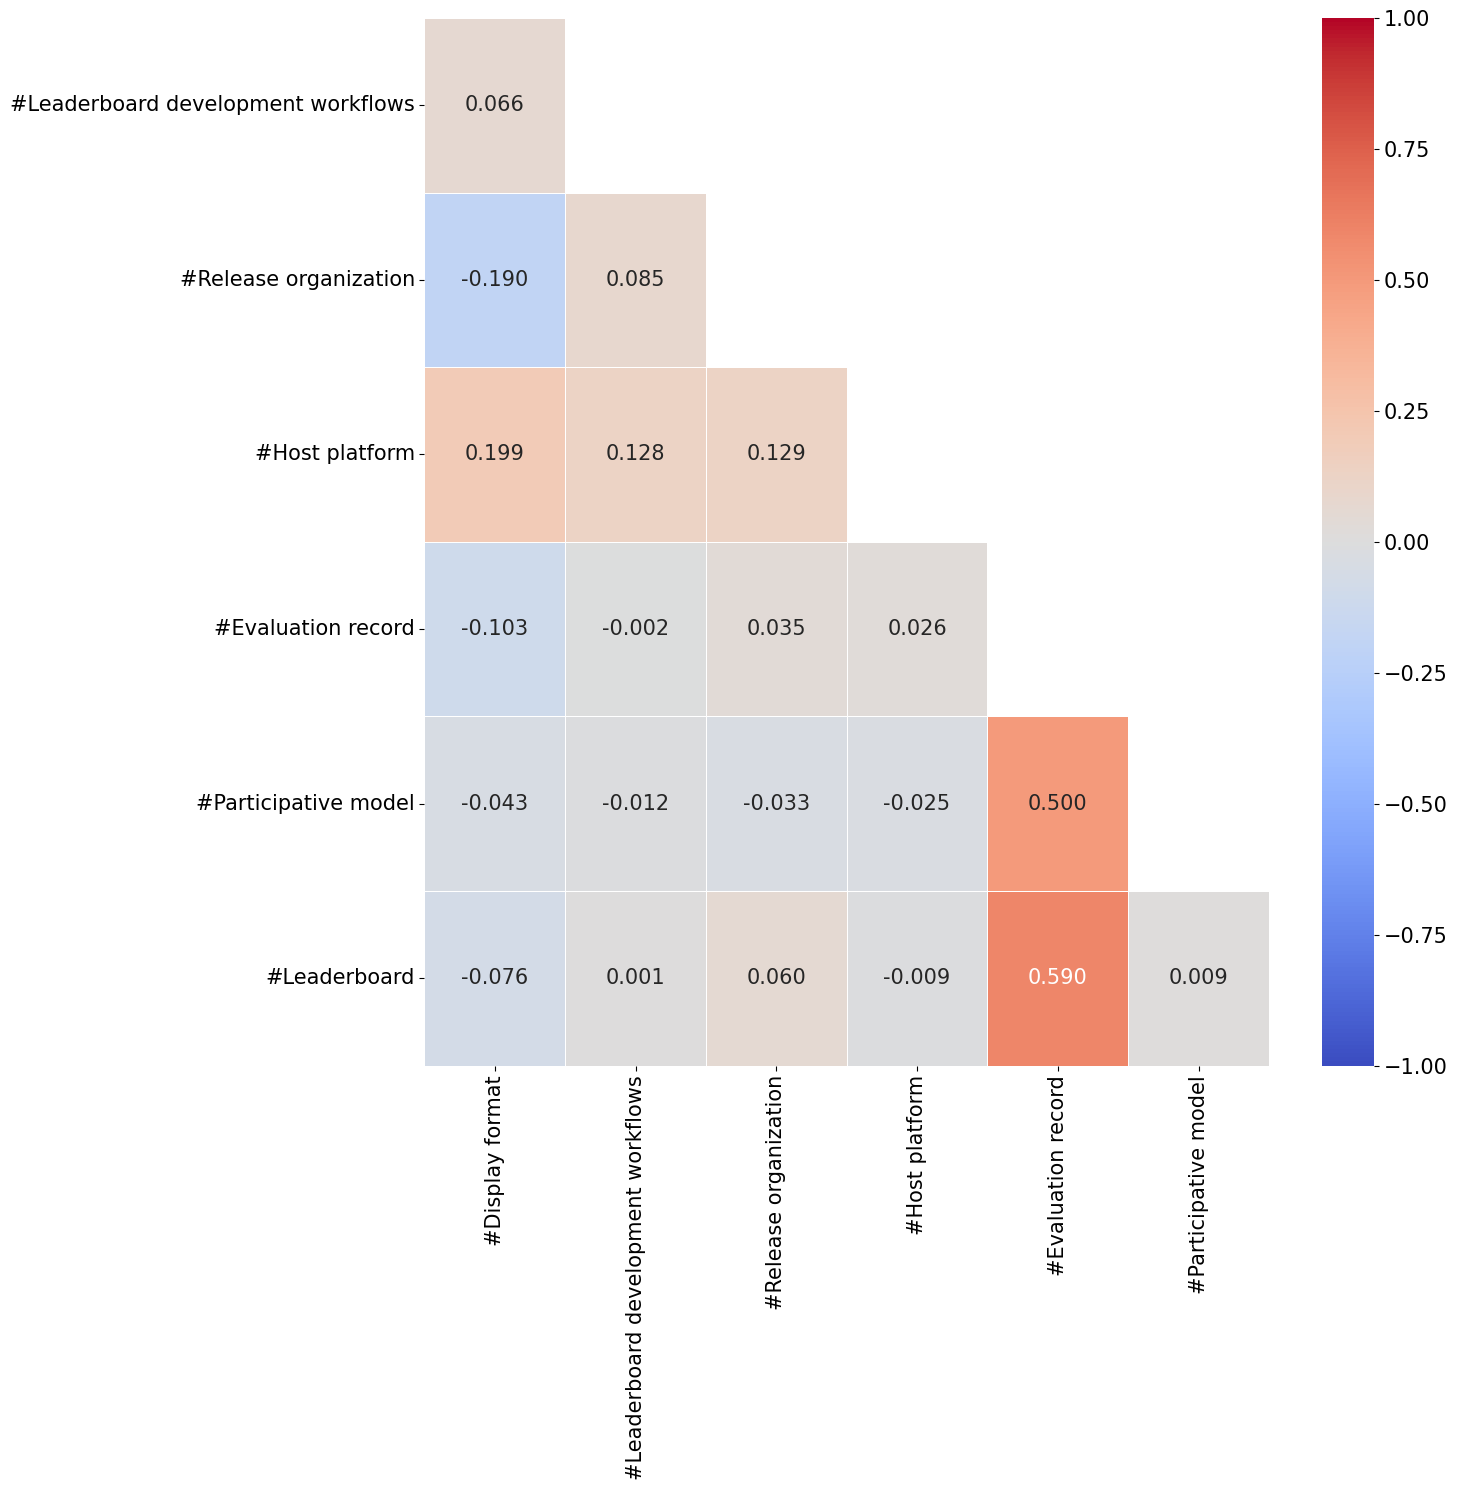

In [6]:
df = pd.read_csv(path_meta / 'leaderboard_processed.csv')
numeric_df = df.select_dtypes(include=['float64', 'int64'])
numeric_df = numeric_df.drop(columns=['#Evaluation metric (pwc)'])
corr_matrix = numeric_df.corr()

# Drop the first row
corr_matrix_dropped_row = corr_matrix.drop(corr_matrix.index[0])

# Drop the last column
corr_matrix_dropped = corr_matrix_dropped_row.drop(corr_matrix_dropped_row.columns[-1], axis=1)

# Generate a mask for the upper triangle, including the diagonal
mask = np.triu(np.ones_like(corr_matrix_dropped, dtype=bool), 1)

# Generate a heatmap for the correlation matrix with the mask
plt.figure(figsize=(15,15))
ax = sns.heatmap(corr_matrix_dropped, annot=True, cmap='coolwarm', fmt=".3f", linewidths=.5, mask=mask, vmin=-1, vmax=1, annot_kws={"size": font_size})
# Enlarge axis font size
ax.tick_params(axis='both', which='major', labelsize=font_size)
# Rotate y-axis labels to horizontal
ax.set_yticklabels(ax.get_yticklabels(), rotation=0) 
ax.set_xticklabels(ax.get_xticklabels(), rotation=90) 
# Adjust color bar (color scale) font size
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=font_size)  # Adjusts the tick labels' font size

plt.tight_layout()  # Adjust the layout to make sure everything fits
plt.show()


In [7]:
df = pd.read_csv(path_meta / 'leaderboard_processed.csv')
df['Platforms'] = df['Platforms'].apply(ast.literal_eval)
df['Platforms'] = df['Platforms'].apply(lambda x: [platform_abbreviation_mapping_inverse[platform] for platform in x])
df['Platforms'] = df['Platforms'].apply(lambda x: ','.join(x).upper())
df = df.explode('Platforms')['Platforms'].value_counts().reset_index(name='Frequency')

fig = px.bar(
    x=df['Platforms'],
    y=df['Frequency'],
    text_auto=True,
    labels={'x': 'Host Platform Combination', 'y': 'Number of Leaderboards'},
)
# Update the layout for a tighter look
fig.update_layout(
    autosize=True,
    margin=dict(
        l=10,  # Left margin
        r=10,  # Right margin
        b=10,  # Bottom margin
        t=10,  # Top margin
        pad=4  # Padding between the plot and the margin
    ),
    xaxis=dict(title_font=dict(size=18, family='Arial, bold', color='black')),  # Bold x-axis label
    yaxis=dict(title_font=dict(size=18, family='Arial, bold', color='black'))   # Bold y-axis label
)
pio.write_image(fig, f'{path_meta}/platform-combo-distribution.pdf')
fig.show()

In [8]:
df = pd.read_csv(path_meta / 'leaderboard_processed.csv')
df['Platforms'] = df['Platforms'].apply(ast.literal_eval)
print(f"{round(len(df[df['Platforms'].map(len) > 1])/len(df)*100,2)}% ({len(df[df['Platforms'].map(len) > 1])} out of {len(df)}) leaderboards are hosted on multiple platforms.")

df_split = df.explode('Platforms')['Platforms'].value_counts().reset_index(name='Frequency')
print(f"{df_split['Platforms'].iloc[0]} is the most popular host platform, accounting for {round(df_split['Frequency'].iloc[0]/len(df)*100,2)}% ({df_split['Frequency'].iloc[0]} out of {len(df)}) leaderboards.")
df_split['Weight'] = 1

statistics = {
    'Distribution': 'Leaderboards across Platforms',
    'Mean': np.mean(df_split['Frequency']),
    'Median': np.median(df_split['Frequency']),
    'IQR': df_split['Frequency'].quantile(0.75) - df_split['Frequency'].quantile(0.25),
    'Gini Coefficient': ineqpy.inequality.gini(data=df_split, income='Frequency', weights='Weight'),
}
if os.path.exists(path_meta / 'leaderboard_statistics.csv'):
    df_statistics = pd.read_csv(path_meta / 'leaderboard_statistics.csv')
else:
    df_statistics = pd.DataFrame()
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.drop_duplicates(subset=['Distribution'], keep='last', inplace=True)
df_statistics.sort_values(by='Distribution', inplace=True)
df_statistics.to_csv(path_meta / 'leaderboard_statistics.csv', index=False)

df_split['Ratio'] = round(df_split['Frequency'] / len(df) * 100, 2)

fig = px.bar(
    x=df_split['Platforms'],
    y=df_split['Frequency'],
    text_auto=True,
    labels={'x': 'Platforms', 'y': 'Number of Leaderboards'},
)
# Update the layout for a tighter look
fig.update_layout(
    autosize=True,
    margin=dict(
        l=10,  # Left margin
        r=10,  # Right margin
        b=10,  # Bottom margin
        t=10,  # Top margin
        pad=4  # Padding between the plot and the margin
    )
)
# Add Ratio as text on each bar
for i, d in enumerate(df_split.itertuples()):
    fig.add_annotation(
        x=d.Platforms,
        y=d.Frequency,
        text=f'{d.Ratio}%',
        showarrow=False,
        yshift=10
    )
fig.show()

11.76% (52 out of 442) leaderboards are hosted on multiple platforms.
Papers With Code is the most popular host platform, accounting for 43.67% (193 out of 442) leaderboards.


In [40]:
df = pd.read_csv(path_meta / 'leaderboard_processed.csv')
df['Display formats'] = df['Display formats'].apply(ast.literal_eval)

df_multiple = df[df['#Display format'] > 1]
print(f"{round(len(df_multiple)/len(df)*100,2)}% ({len(df_multiple)} out of {len(df)}) leaderboards support multiple display formats.")
display_format_rankable = ['Rankable Table', 'Rankable Bar Chart']
df_rankable = keep_rows_by_list_column(df, 'Display formats', display_format_rankable)
print(f"{round(len(df_rankable)/len(df)*100,2)}% ({len(df_rankable)} out of {len(df)}) leaderboards support rankable display formats.")
df_rankable_split = df_rankable.explode('Display formats')['Display formats'].value_counts().reset_index(name='Frequency')
print(f"{df_rankable_split['Display formats'].iloc[0]} is the most popular display format of rankable leaderboards, accounting for {round(df_rankable_split['Frequency'].iloc[0]/len(df_rankable)*100,2)}% ({df_rankable_split['Frequency'].iloc[0]} out of {len(df_rankable)}) rankable leaderboards.")
df_split = df.explode('Display formats')['Display formats'].value_counts().reset_index(name='Frequency')
df_split['Weight'] = 1

statistics = {
    'Distribution': 'Leaderboards across Display Formats',
    'Mean': np.mean(df_split['Frequency']),
    'Median': np.median(df_split['Frequency']),
    'IQR': df_split['Frequency'].quantile(0.75) - df_split['Frequency'].quantile(0.25),
    'Gini Coefficient': ineqpy.inequality.gini(data=df_split, income='Frequency', weights='Weight'),
}
if os.path.exists(path_meta / 'leaderboard_statistics.csv'):
    df_statistics = pd.read_csv(path_meta / 'leaderboard_statistics.csv')
else:
    df_statistics = pd.DataFrame()
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.drop_duplicates(subset=['Distribution'], keep='last', inplace=True)
df_statistics.sort_values(by='Distribution', inplace=True)
df_statistics.to_csv(path_meta / 'leaderboard_statistics.csv', index=False)

df_split['Ratio'] = round(df_split['Frequency'] / len(df) * 100, 2)

fig = px.bar(
    x=df_split['Display formats'],
    y=df_split['Ratio'],
    text_auto=True,
    labels={'x': 'Display format', 'y': 'Number of Leaderboards'},
)
# Update the layout for a tighter look
fig.update_layout(
    autosize=True,
    margin=dict(
        l=10,  # Left margin
        r=10,  # Right margin
        b=10,  # Bottom margin
        t=10,  # Top margin
        pad=4  # Padding between the plot and the margin
    )
)
fig.show()

62.44% (276 out of 442) leaderboards support multiple display formats.
77.38% (342 out of 442) leaderboards support rankable display formats.
Rankable Table is the most popular display format of rankable leaderboards, accounting for 99.71% (341 out of 342) rankable leaderboards.


In [10]:
df = pd.read_csv(path_meta / 'leaderboard_processed.csv')
df['Downloadable file formats (non-pwc)'] = df['Downloadable file formats (non-pwc)'].apply(ast.literal_eval)
print(f"{round(len(df[df['Downloadable file formats (non-pwc)'].map(len) > 0])/len(df)*100,2)}% ({len(df[df['Downloadable file formats (non-pwc)'].map(len) > 0])} out of {len(df)}) leaderboards provide downloadable files of the leaderboards.")

df = df[df['Downloadable file formats (non-pwc)'].map(len) > 0]
df_split = df.explode('Downloadable file formats (non-pwc)')['Downloadable file formats (non-pwc)'].value_counts().reset_index(name='Frequency')
print(f"{df_split['Downloadable file formats (non-pwc)'].iloc[0]} is the most popular storage format of leaderboards, accounting for {round(df_split['Frequency'].iloc[0]/len(df)*100,2)}% ({df_split['Frequency'].iloc[0]} out of {len(df)}) downloadable leaderboards.")
df_split['Weight'] = 1

statistics = {
    'Distribution': 'Leaderboards across Downloadable File Formats',
    'Mean': np.mean(df_split['Frequency']),
    'Median': np.median(df_split['Frequency']),
    'IQR': df_split['Frequency'].quantile(0.75) - df_split['Frequency'].quantile(0.25),
    'Gini Coefficient': ineqpy.inequality.gini(data=df_split, income='Frequency', weights='Weight'),
}
if os.path.exists(path_meta / 'leaderboard_statistics.csv'):
    df_statistics = pd.read_csv(path_meta / 'leaderboard_statistics.csv')
else:
    df_statistics = pd.DataFrame()
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.drop_duplicates(subset=['Distribution'], keep='last', inplace=True)
df_statistics.sort_values(by='Distribution', inplace=True)
df_statistics.to_csv(path_meta / 'leaderboard_statistics.csv', index=False)

df_split['Ratio'] = round(df_split['Frequency'] / len(df) * 100, 2)

fig = px.bar(
    x=df_split['Downloadable file formats (non-pwc)'],
    y=df_split['Ratio'],
    text_auto=True,
    labels={'x': 'Downloadable File Formats', 'y': 'Number of Leaderboards'},
)
# Update the layout for a tighter look
fig.update_layout(
    autosize=True,
    margin=dict(
        l=10,  # Left margin
        r=10,  # Right margin
        b=10,  # Bottom margin
        t=10,  # Top margin
        pad=4  # Padding between the plot and the margin
    )
)
fig.show()

12.9% (57 out of 442) leaderboards provide downloadable files of the leaderboards.
CSV is the most popular storage format of leaderboards, accounting for 78.95% (45 out of 57) downloadable leaderboards.


In [11]:
df = pd.read_csv(path_meta / 'leaderboard_processed.csv')

df['Release organizations'] = df['Release organizations'].apply(ast.literal_eval)
df_split = df.explode('Release organizations').groupby('Release organizations').size().reset_index(name='Frequency')
df_split['Weight'] = 1

statistics = {
    'Distribution': 'Leaderboards across Release Organizations',
    'Mean': np.mean(df_split['Frequency']),
    'Median': np.median(df_split['Frequency']),
    'IQR': df_split['Frequency'].quantile(0.75) - df_split['Frequency'].quantile(0.25),
    'Gini Coefficient': ineqpy.inequality.gini(data=df_split, income='Frequency', weights='Weight'),
}
if os.path.exists(path_meta / 'leaderboard_statistics.csv'):
    df_statistics = pd.read_csv(path_meta / 'leaderboard_statistics.csv')
else:
    df_statistics = pd.DataFrame()
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.drop_duplicates(subset=['Distribution'], keep='last', inplace=True)
df_statistics.sort_values(by='Distribution', inplace=True)
df_statistics.to_csv(path_meta / 'leaderboard_statistics.csv', index=False)

df_top = df_split.sort_values(by='Frequency', ascending=False).head(10)
print(f"{df_top['Release organizations'].iloc[0]} stands out as the most prolific release organization among the {len(df_split['Release organizations'].unique())-1} identified organizations, contributing to a notable {round(df_top['Frequency'].iloc[0]/len(df)*100,2)}% ({df_top['Frequency'].iloc[0]} out of {len(df)}) leaderboards.")

df_top['Ratio'] = round(df_top['Frequency'] / len(df) * 100, 2)

fig = go.Figure(go.Bar(
        x=df_top['Frequency'],  # Values for the bar lengths
        y=df_top['Release organizations'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['Ratio'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        title=f'Number of Leaderboards across Release Organizations (Top 10)',
        xaxis_title='Leaderboard Number',
        yaxis_title='Publisher Name',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
fig.show()


Papers With Code stands out as the most prolific release organization among the 236 identified organizations, contributing to a notable 42.76% (189 out of 442) leaderboards.


In [12]:
df = pd.read_csv(path_meta / 'leaderboard_processed.csv')
df = df[df['Platforms'] != "['Papers With Code']"]

statistics = {
    'Distribution': 'Release Organizations across Leaderboards',
    'Mean': np.mean(df['#Release organization']),
    'Median': np.median(df['#Release organization']),
    'IQR': df['#Release organization'].quantile(0.75) - df['#Release organization'].quantile(0.25),
}
if os.path.exists(path_meta / 'leaderboard_statistics.csv'):
    df_statistics = pd.read_csv(path_meta / 'leaderboard_statistics.csv')
else:
    df_statistics = pd.DataFrame()
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.drop_duplicates(subset=['Distribution'], keep='last', inplace=True)
df_statistics.sort_values(by='Distribution', inplace=True)
df_statistics.to_csv(path_meta / 'leaderboard_statistics.csv', index=False)

df_top = df.drop_duplicates(subset=['Leaderboard name']).sort_values(by='#Release organization', ascending=False).head(10)
print(f"{df_top['Leaderboard name'].iloc[0]} holds the highest number of release organizations up to {int(df_top['#Release organization'].iloc[0])}.")

fig = go.Figure(go.Bar(
        x=df_top['#Release organization'],  # Values for the bar lengths
        y=df_top['Leaderboard name'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['#Release organization'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        xaxis_title='Number of Release Organization',
        yaxis_title='Leaderboard Name',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
# Update the layout for a tighter look
fig.update_layout(
    autosize=True,
    margin=dict(
        l=10,  # Left margin
        r=10,  # Right margin
        b=10,  # Bottom margin
        t=10,  # Top margin
        pad=4  # Padding between the plot and the margin
    )
)
fig.show()


TrustLLM holds the highest number of release organizations up to 36.


In [13]:
df = pd.read_csv(path_meta / 'leaderboard_processed.csv')
df['Publication venues'] = df['Publication venues'].apply(ast.literal_eval)
df_pub = df[df['Publication venues'].apply(len) > 0]
print(f"{round(len(df_pub)/len(df)*100,2)}% ({len(df_pub)} out of {len(df)}) leaderboards are associated with specific publications, including research articles, blog posts, and white papers.")

df_literature = filter_rows_by_list_column(df_pub, 'Publication venues', non_literature_type)
print(f"{round(len(df_literature)/len(df_pub)*100,2)}% ({len(df_literature)} out of {len(df_pub)}) publications have been accepted in a specific workshop, conference, magzine, or journal.")
df_split = df_literature.explode('Publication venues').groupby('Publication venues').size().reset_index(name='Frequency')
df_split['Weight'] = 1

statistics = {
    'Distribution': 'Leaderboards across Publication Venues',
    'Mean': np.mean(df_split['Frequency']),
    'Median': np.median(df_split['Frequency']),
    'IQR': df_split['Frequency'].quantile(0.75) - df_split['Frequency'].quantile(0.25),
    'Gini Coefficient': ineqpy.inequality.gini(data=df_split, income='Frequency', weights='Weight'),
}
if os.path.exists(path_meta / 'leaderboard_statistics.csv'):
    df_statistics = pd.read_csv(path_meta / 'leaderboard_statistics.csv')
else:
    df_statistics = pd.DataFrame()
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.drop_duplicates(subset=['Distribution'], keep='last', inplace=True)
df_statistics.sort_values(by='Distribution', inplace=True)
df_statistics.to_csv(path_meta / 'leaderboard_statistics.csv', index=False)

df_top = df_split.sort_values(by='Frequency', ascending=False).head(10)
print(f"{df_top['Publication venues'].iloc[0]} emerges as the conference with the most number of accepted publications, accounting for {round(df_top['Frequency'].iloc[0]/len(df_literature)*100,2)}% ({df_top['Frequency'].iloc[0]} out of {len(df_literature)}) of those published.")

df_top['Ratio'] = round(df_top['Frequency'] / len(df_literature) * 100, 2)

fig = go.Figure(go.Bar(
        x=df_top['Frequency'],  # Values for the bar lengths
        y=df_top['Publication venues'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['Ratio'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        title=f'Number of Leaderboards with Accepted Publications across Publication Venues (Top 10)',
        xaxis_title='Leaderboard Number',
        yaxis_title='Publication Name',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
fig.show()


85.29% (377 out of 442) leaderboards are associated with specific publications, including research articles, blog posts, and white papers.
61.54% (232 out of 377) publications have been accepted in a specific workshop, conference, magzine, or journal.
EMNLP emerges as the conference with the most number of accepted publications, accounting for 16.81% (39 out of 232) of those published.


In [14]:
df = pd.read_csv(path_meta / 'leaderboard_processed.csv')

statistics = {
    'Distribution': 'Participative Models across Leaderboards',
    'Mean': np.mean(df['#Participative model']),
    'Median': np.median(df['#Participative model']),
    'IQR': df['#Participative model'].quantile(0.75) - df['#Participative model'].quantile(0.25),
}
if os.path.exists(path_meta / 'leaderboard_statistics.csv'):
    df_statistics = pd.read_csv(path_meta / 'leaderboard_statistics.csv')
else:
    df_statistics = pd.DataFrame()
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.drop_duplicates(subset=['Distribution'], keep='last', inplace=True)
df_statistics.sort_values(by='Distribution', inplace=True)
df_statistics.to_csv(path_meta / 'leaderboard_statistics.csv', index=False)

df_top = df.drop_duplicates(subset=['Leaderboard name']).sort_values(by='#Participative model', ascending=False).head(10)
print(f"{df_top['Leaderboard name'].iloc[0]} has the highest number of {int(df_top['#Participative model'].iloc[0])} participative models.")

fig = go.Figure(go.Bar(
        x=df_top['#Participative model'],  # Values for the bar lengths
        y=df_top['Leaderboard name'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['#Participative model'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        xaxis_title='Number of Participative Models',
        yaxis_title='Leaderboard Name',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
# Update the layout for a tighter look
fig.update_layout(
    autosize=True,
    margin=dict(
        l=10,  # Left margin
        r=10,  # Right margin
        b=10,  # Bottom margin
        t=10,  # Top margin
        pad=4  # Padding between the plot and the margin
    )
)
fig.show()


Open LLM Leaderboard (GPT) has the highest number of 5485 participative models.


In [15]:
df = pd.read_csv(path_meta / 'leaderboard_processed.csv')
df = df[df['Platforms'] == "['Papers With Code']"]

statistics = {
    'Distribution': 'Evaluation Metrics across Leaderboards',
    'Mean': np.mean(df['#Evaluation metric (pwc)']),
    'Median': np.median(df['#Evaluation metric (pwc)']),
    'IQR': df['#Evaluation metric (pwc)'].quantile(0.75) - df['#Evaluation metric (pwc)'].quantile(0.25),
}
if os.path.exists(path_meta / 'leaderboard_statistics.csv'):
    df_statistics = pd.read_csv(path_meta / 'leaderboard_statistics.csv')
else:
    df_statistics = pd.DataFrame()
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.drop_duplicates(subset=['Distribution'], keep='last', inplace=True)
df_statistics.sort_values(by='Distribution', inplace=True)
df_statistics.to_csv(path_meta / 'leaderboard_statistics.csv', index=False)

df_top = df.drop_duplicates(subset=['Leaderboard name']).sort_values(by='#Evaluation metric (pwc)', ascending=False).head(10)
print(f"{df_top['Leaderboard name'].iloc[0]} has the highest number of {int(df_top['#Evaluation metric (pwc)'].iloc[0])} evaluation metrics.")

fig = go.Figure(go.Bar(
        x=df_top['#Evaluation metric (pwc)'],  # Values for the bar lengths
        y=df_top['Leaderboard name'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['#Evaluation metric (pwc)'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        xaxis_title='Number of Evaluation Metrics',
        yaxis_title='Leaderboard Name',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
# Update the layout for a tighter look
fig.update_layout(
    autosize=True,
    margin=dict(
        l=10,  # Left margin
        r=10,  # Right margin
        b=10,  # Bottom margin
        t=10,  # Top margin
        pad=4  # Padding between the plot and the margin
    )
)
fig.show()


ChEBI-20 has the highest number of 20 evaluation metrics.


In [16]:
df = pd.read_csv(path_meta / 'leaderboard_processed.csv')
df = df[df['Platforms'] == "['Papers With Code']"]
df['Evaluation metrics (pwc)'] = df['Evaluation metrics (pwc)'].apply(ast.literal_eval)

df_split = df.explode('Evaluation metrics (pwc)').groupby('Evaluation metrics (pwc)').size().reset_index(name='Frequency')
df_split['Weight'] = 1

statistics = {
    'Distribution': 'Leaderboards across Evaluation Metrics',
    'Mean': np.mean(df_split['Frequency']),
    'Median': np.median(df_split['Frequency']),
    'IQR': df_split['Frequency'].quantile(0.75) - df_split['Frequency'].quantile(0.25),
    'Gini Coefficient': ineqpy.inequality.gini(data=df_split, income='Frequency', weights='Weight'),
}
if os.path.exists(path_meta / 'leaderboard_statistics.csv'):
    df_statistics = pd.read_csv(path_meta / 'leaderboard_statistics.csv')
else:
    df_statistics = pd.DataFrame()
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.drop_duplicates(subset=['Distribution'], keep='last', inplace=True)
df_statistics.sort_values(by='Distribution', inplace=True)
df_statistics.to_csv(path_meta / 'leaderboard_statistics.csv', index=False)

df_top = df_split.drop_duplicates(subset=['Evaluation metrics (pwc)']).sort_values(by='Frequency', ascending=False).head(10)
print(f"{df_top['Evaluation metrics (pwc)'].iloc[0]} is the most prevalent evaluation metrics in {round(df_top['Frequency'].iloc[0]/len(df)*100,2)}% ({df_top['Frequency'].iloc[0]} out of {len(df)}) leaderboards.")

fig = go.Figure(go.Bar(
        x=df_top['Frequency'],  # Values for the bar lengths
        y=df_top['Evaluation metrics (pwc)'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['Frequency'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        xaxis_title='Leaderboard Number',
        yaxis_title='Evaluation Metric',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
# Update the layout for a tighter look
fig.update_layout(
    autosize=True,
    margin=dict(
        l=10,  # Left margin
        r=10,  # Right margin
        b=10,  # Bottom margin
        t=10,  # Top margin
        pad=4  # Padding between the plot and the margin
    )
)
fig.show()

accuracy is the most prevalent evaluation metrics in 41.27% (78 out of 189) leaderboards.


In [17]:
df = pd.read_csv(path_meta / 'leaderboard_processed.csv')
df['Weight'] = 1

statistics = {
    'Distribution': 'Leaderboards across Leaderboards',
    'Mean': np.mean(df['#Leaderboard']),
    'Median': np.median(df['#Leaderboard']),
    'IQR': df['#Leaderboard'].quantile(0.75) - df['#Leaderboard'].quantile(0.25),
    'Gini Coefficient': ineqpy.inequality.gini(data=df, income='#Leaderboard', weights='Weight'),
}
if os.path.exists(path_meta / 'leaderboard_statistics.csv'):
    df_statistics = pd.read_csv(path_meta / 'leaderboard_statistics.csv')
else:
    df_statistics = pd.DataFrame()
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.drop_duplicates(subset=['Distribution'], keep='last', inplace=True)
df_statistics.sort_values(by='Distribution', inplace=True)
df_statistics.to_csv(path_meta / 'leaderboard_statistics.csv', index=False)

df_top = df.drop_duplicates(subset=['Leaderboard name']).sort_values(by='#Leaderboard', ascending=False).head(10)
print(f"{df_top['Leaderboard name'].iloc[0]} has the highest number of {int(df_top['#Leaderboard'].iloc[0])} leaderboards.")

fig = go.Figure(go.Bar(
        x=df_top['#Leaderboard'],  # Values for the bar lengths
        y=df_top['Leaderboard name'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['#Leaderboard'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        xaxis_title='Split Number',
        yaxis_title='Leaderboard Name',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
# Update the layout for a tighter look
fig.update_layout(
    autosize=True,
    margin=dict(
        l=10,  # Left margin
        r=10,  # Right margin
        b=10,  # Bottom margin
        t=10,  # Top margin
        pad=4  # Padding between the plot and the margin
    )
)
fig.show()


LMExamQA has the highest number of 887 leaderboards.


In [18]:
df = pd.read_csv(path_meta / 'leaderboard_processed.csv')
df['Weight'] = 1

statistics = {
    'Distribution': 'Evaluation Records across Leaderboards',
    'Mean': np.mean(df['#Evaluation record']),
    'Median': np.median(df['#Evaluation record']),
    'IQR': df['#Evaluation record'].quantile(0.75) - df['#Evaluation record'].quantile(0.25),
    'Gini Coefficient': ineqpy.inequality.gini(data=df, income='#Evaluation record', weights='Weight'),
}
if os.path.exists(path_meta / 'leaderboard_statistics.csv'):
    df_statistics = pd.read_csv(path_meta / 'leaderboard_statistics.csv')
else:
    df_statistics = pd.DataFrame()
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.drop_duplicates(subset=['Distribution'], keep='last', inplace=True)
df_statistics.sort_values(by='Distribution', inplace=True)
df_statistics.to_csv(path_meta / 'leaderboard_statistics.csv', index=False)

df_top = df.drop_duplicates(subset=['Leaderboard name']).sort_values(by='#Evaluation record', ascending=False).head(10)
print(f"{df_top['Leaderboard name'].iloc[0]} has the highest number of {int(df_top['#Evaluation record'].iloc[0])} evaluation records.")

fig = go.Figure(go.Bar(
        x=df_top['#Evaluation record'],  # Values for the bar lengths
        y=df_top['Leaderboard name'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['#Evaluation record'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        xaxis_title='Number of Evaluation Records',
        yaxis_title='Leaderboard Name',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
# Update the layout for a tighter look
fig.update_layout(
    autosize=True,
    margin=dict(
        l=10,  # Left margin
        r=10,  # Right margin
        b=10,  # Bottom margin
        t=10,  # Top margin
        pad=4  # Padding between the plot and the margin
    )
)
fig.show()


HELM Classic has the highest number of 16005 evaluation records.


In [26]:
df = pd.read_csv(path_meta / 'leaderboard_processed.csv')
df['Leaderboard development workflows'] = df['Leaderboard development workflows'].apply(ast.literal_eval)

df = df[df['Leaderboard development workflows'].map(len) > 0]
df_workflow = df.explode('Leaderboard development workflows')
df_workflow = df_workflow.groupby('Leaderboard development workflows').size().reset_index(name='Frequency')
df_workflow['Leaderboard development workflows'] = df_workflow['Leaderboard development workflows'].apply(lambda x: f'Type {x}' if x != 'Unknown' else x)
df_workflow.sort_values(by='Frequency', ascending=False, inplace=True)
df_workflow['Weight'] = 1

print(f"{df_workflow['Leaderboard development workflows'].iloc[0]} is the most prevalent ({df_workflow['Frequency'].iloc[0]} out of {len(df)}) workflow type that accounts for {round(df_workflow['Frequency'].iloc[0]/len(df)*100,2)}%.")
df_pwc = df[df['Platforms'] == "['Papers With Code']"]
print(f'In {df_workflow["Leaderboard development workflows"].iloc[0]}, {round(len(df_pwc)/df_workflow["Frequency"].iloc[0]*100,2)}% ({len(df_pwc)} out of {df_workflow["Frequency"].iloc[0]}) of the leaderboards are hosted on Papers With Code.')
print(f"There are {round(df_workflow[df_workflow['Leaderboard development workflows'] == 'Unknown']['Frequency'].iloc[0]/(len(df)-len(df_pwc))*100,2)}% ({df_workflow[df_workflow['Leaderboard development workflows'] == 'Unknown']['Frequency'].iloc[0]} out of {len(df)-len(df_pwc)}) non-PWC leaderboards with unknown workflow types.")

statistics = {
    'Distribution': 'Leaderboards across Workflow Types',
    'Mean': np.mean(df_workflow['Frequency']),
    'Median': np.median(df_workflow['Frequency']),
    'IQR': df_workflow['Frequency'].quantile(0.75) - df_workflow['Frequency'].quantile(0.25),
    'Gini Coefficient': ineqpy.inequality.gini(data=df_workflow[df_workflow['Leaderboard development workflows'] != 'Unknown'], income='Frequency', weights='Weight'),
}
if os.path.exists(path_meta / 'leaderboard_statistics.csv'):
    df_statistics = pd.read_csv(path_meta / 'leaderboard_statistics.csv')
else:
    df_statistics = pd.DataFrame()
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.drop_duplicates(subset=['Distribution'], keep='last', inplace=True)
df_statistics.sort_values(by='Distribution', inplace=True)
df_statistics.to_csv(path_meta / 'leaderboard_statistics.csv', index=False)

df_workflow['Ratio'] = round(df_workflow['Frequency'] / len(df) * 100, 2)
fig = px.bar(
    x=df_workflow['Leaderboard development workflows'], 
    y=df_workflow['Ratio'],
    text_auto=True,
    labels={'x': 'Leaderboard development workflows', 'y': 'Leaderboard Number'},
    title='Number of Leaderboards across Workflow Types (non-pwc)'
)
fig.show()

Type 1 is the most prevalent (213 out of 442) workflow type that accounts for 48.19%.
In Type 1, 88.73% (189 out of 213) of the leaderboards are hosted on Papers With Code.
There are 3.56% (9 out of 253) non-PWC leaderboards with unknown workflow types.


In [20]:
# df = pd.read_csv(path_meta / 'leaderboard_processed.csv')
# df = df[df['Platforms'] == "['Papers With Code']"]

# total = 0
# community = 0
# evaluation = 0

# for root, dirs, files in os.walk(path_data):
#     for file in files:
#         if file.startswith('pwc') and file.endswith(".json"):
#             total += 1
#             if 'community' in file:
#                 community += 1
#             else:
#                 evaluation += 1

# pwc_workflow_pattern_mapping = {
#     'Workflow Type 7': f'{round(evaluation/total*100, 2)}% ({evaluation} out of {total})',
#     'Workflow Type 8': f'{round(community/total*100, 2)}% ({community} out of {total}))'
# }
# pwc_workflow_pattern_mapping

In [21]:
df = pd.read_csv(path_meta / 'leaderboard_processed.csv')
print(f"{round((len(df)-len(leaderboard_system_without_documentation))/(len(df))*100, 2)}% ({len(df)-len(leaderboard_system_without_documentation)} out of {len(df)}) leaderboards provide documentation.")
print(f"{round((len(df)-len(leaderboard_system_without_contacts))/(len(df))*100, 2)}% ({len(df)-len(leaderboard_system_without_contacts)} out of {len(df)}) leaderboards provide contact information.")
print(f"{round((len(df[df['Model linkage (non-pwc)'].notna()]))/(len(df))*100, 2)}% ({len(df[df['Model linkage (non-pwc)'].notna()])} out of {len(df)}) leaderboards provide provenance links of their participating models within their documentation or directly on the leaderboards.")
df['Leaderboard development workflows'] = df['Leaderboard development workflows'].apply(ast.literal_eval)
df_submission = keep_rows_by_list_column(df, 'Leaderboard development workflows', workflow_patterns_with_submission)
print(f"{round(len(df_submission)/(len(df))*100, 2)}% ({len(df_submission)} out of {len(df)}) leaderboards provide submission channels.")
df_pwc = df[df['Platforms'] == "['Papers With Code']"]
print(f"{round((len(df)-len(leaderboard_system_without_evaluation_harness)-len(df_pwc))/(len(df))*100, 2)}% ({len(df)-len(leaderboard_system_without_evaluation_harness)-len(df_pwc)} out of {len(df)}) leaderboards provide evaluation harness.")
print(f"{round((len(df)-len(leaderboard_system_without_pull_requests)-len(df_pwc))/(len(df))*100, 2)}% ({len(df)-len(leaderboard_system_without_pull_requests)-len(df_pwc)} out of {len(df)}) leaderboards provide pull request channels.")
print(f"{round((len(df)-len(leaderboard_system_without_pull_requests)-len(df_pwc))/(len(df))*100, 2)}% ({len(df)-len(leaderboard_system_without_pull_requests)-len(df_pwc)} out of {len(df)}) leaderboards provide discussion forums.")

99.32% (439 out of 442) leaderboards provide documentation.
99.77% (441 out of 442) leaderboards provide contact information.
28.96% (128 out of 442) leaderboards provide provenance links of their participating models within their documentation or directly on the leaderboards.
74.43% (329 out of 442) leaderboards provide submission channels.
56.56% (250 out of 442) leaderboards provide evaluation harness.
54.52% (241 out of 442) leaderboards provide pull request channels.
54.52% (241 out of 442) leaderboards provide discussion forums.


In [22]:
df = pd.read_csv(path_meta / 'leaderboard_processed.csv')
print(f"{round(len(df[df['#Empty leaderboards (non-pwc)'].notna()])/len(df)*100,2)}% ({len(df[df['#Empty leaderboards (non-pwc)'].notna()])} out of {len(df)}) leaderboards have empty leaderboards.")
df['#Empty leaderboards (non-pwc)'].value_counts().reset_index(name='Frequency')

1.13% (5 out of 442) leaderboards have empty leaderboards.


,#Empty leaderboards (non-pwc),Frequency
0,2,2
1,Unknown,2
2,25,1


In [23]:
df = pd.read_csv(path_meta / 'leaderboard_statistics.csv')
df.fillna('$\\times$', inplace=True)
df['Mean'] = df['Mean'].map('{:.2f}'.format)
df['Median'] = df['Median'].map('{:.1f}'.format)
df['IQR'] = df['IQR'].map('{:.0f}'.format)
df['Gini Coefficient'] = df['Gini Coefficient'].map(lambda x: '{:.3f}'.format(x) if isinstance(x,float) else x)
print(df.to_latex(index=False))


\begin{tabular}{lllll}
\toprule
Distribution & Mean & Median & IQR & Gini Coefficient \\
\midrule
Evaluation Metrics across Leaderboards & 3.20 & 2.0 & 3 & $\times$ \\
Evaluation Records across Leaderboards & 188.90 & 23.0 & 48 & 0.873 \\
Leaderboards across Display Formats & 67.55 & 5.0 & 72 & 0.809 \\
Leaderboards across Downloadable File Formats & 7.50 & 2.0 & 2 & 0.795 \\
Leaderboards across Evaluation Metrics & 2.27 & 1.0 & 1 & 0.501 \\
Leaderboards across Leaderboards & 6.76 & 1.0 & 2 & 0.796 \\
Leaderboards across Platforms & 124.25 & 109.0 & 55 & 0.241 \\
Leaderboards across Publication Venues & 3.89 & 1.0 & 1 & 0.647 \\
Leaderboards across Release Organizations & 3.49 & 1.0 & 1 & 0.631 \\
Leaderboards across Workflow Patterns & 50.00 & 9.0 & 66 & 0.721 \\
Participative Models across Leaderboards & 73.47 & 17.0 & 26 & $\times$ \\
Release Organizations across Leaderboards & 2.51 & 2.0 & 2 & $\times$ \\
\bottomrule
\end{tabular}



/var/folders/p7/fg_w39cx6pq23vf3798tdmq00000gn/T/ipykernel_14366/4002361276.py:2: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '$\times$' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.



In [25]:
total_smell_count = 0

# Load the Excel file
with pd.ExcelFile(path_meta / 'Foundation Model Leaderboards.xlsx') as xls:

    # Initialize a dictionary to store unique counts
    unique_counts = {}

    # Iterate over each sheet
    for sheet_name in xls.sheet_names:
        if sheet_name in ['Leaderboard']:
            continue
        
        df = pd.read_excel(xls, sheet_name=sheet_name)
        
        if sheet_name == 'Self-admitted Technical Debt':
            print(f'There are {len(df)} self-admitted technical debt examples.')
            continue
    
        # Iterate over each column
        for column in df.columns:
            # Apply the URL filter and count unique valid URLs
            filtered_urls = df[column].dropna()
            unique_count = filtered_urls.nunique()
        
            if sheet_name not in unique_counts:
                unique_counts[sheet_name] = {}
                
            unique_counts[sheet_name][column] = unique_count
            total_smell_count += unique_count

print(f'There are {total_smell_count} leaderboard smell examples.')

# Display the result
pd.DataFrame(unique_counts).transpose()


There are 21 self-admitted technical debt examples.
There are 178 leaderboard smell examples.


,Benchmark Metric,Benchmark Protocol,Benchmark Raw Dataset,Evaluation Record,Model,Ranking Dataframe,Submission Channel,Leaderboard Publication
Confusing Entity,4.0,8.0,21.0,5.0,6.0,4.0,19.0,NaN
Deprecated Entity,NaN,NaN,3.0,1.0,1.0,7.0,3.0,2.0
Inaccessible Entity,NaN,NaN,2.0,3.0,1.0,16.0,5.0,2.0
Misdisplayed Entity,5.0,2.0,NaN,NaN,NaN,5.0,NaN,NaN
Mismatched Entity,3.0,2.0,6.0,6.0,6.0,1.0,NaN,NaN
Missing Entity,NaN,1.0,NaN,7.0,NaN,9.0,1.0,NaN
Redundant Entity,NaN,NaN,NaN,3.0,2.0,4.0,NaN,NaN
Unresponsive Entity,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN
